In [1]:
using Base: @kwdef
using Parameters: @unpack
using LinearAlgebra, PyPlot, Random, Distributions, Statistics, ImageTransformations, TestImages, ColorTypes

In [2]:
@kwdef mutable struct AmariHopfieldModel
    W::Array  # weights
    θ::Vector # thresholds
end

# Training weights & definition of model
function AmariHopfieldModel(inputs; σθ=1e-2)
    num_data, num_units = size(inputs) # inputs : num_data x num_unit
    inputs = mapslices(x -> x .- mean(x), inputs, dims=2)  
    W = (inputs' * inputs) / num_data # hebbian rule
    W -= diagm(diag(W))               # Set the diagonal of weights to zero
    return AmariHopfieldModel(W=W, θ=σθ*randn(num_units))
end;

In [3]:
binarize(img) = 2.0((img .- mean(img)) .> 0) .- 1; # img to {-1, 1}

function corrupted(img, p=0.3)
    mask = rand(Binomial(1, p), size(img));
    return img .* (1 .- mask) - img .* mask; 
end

corrupted (generic function with 2 methods)

In [4]:
testimagelist = ["cameraman", "jetplane", "house", "mandril_gray", "lake_gray"]; # gray & size(512 x 512)
num_data = length(testimagelist)

imgs = [convert(Array{Float64}, imresize(Gray.(testimage(imagename)), ratio=1/8)) for imagename in testimagelist];
imgs_binarized = map(binarize, imgs);
imgs_corrupted = map(corrupted, imgs_binarized);

input_train = reshape(cat(imgs_binarized..., dims=3), (:, num_data))';
input_test = reshape(cat(imgs_corrupted..., dims=3), (:, num_data))';

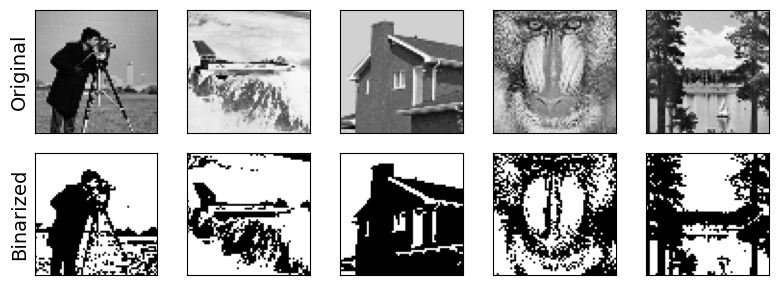

In [5]:
figure(figsize=(8, 3))
for i in 1:num_data
    subplot(2, num_data, i); imshow(imgs[i], cmap="gray"); 
    xticks([]); yticks([]); if i==1 ylabel("Original", fontsize=14) end;
    subplot(2, num_data, i+num_data); imshow(imgs_binarized[i], cmap="gray"); 
    xticks([]); yticks([]); if i==1 ylabel("Binarized", fontsize=14) end;
end
tight_layout()

In [6]:
model = AmariHopfieldModel(input_train);

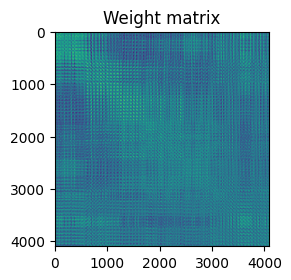

In [7]:
figure(figsize=(3, 3))
title("Weight matrix"); imshow(model.W); 
tight_layout()

In [8]:
energy(W, s, θ) = -0.5s' * W * s + θ' * s

# Synchronous update
function prediction(model::AmariHopfieldModel, init_s, max_iter=100)
    @unpack W, θ = model
    s, e = init_s, energy(W, init_s, θ)
    for t in 1:max_iter
        s = sign.(W * s - θ)    # update s
        e_tp1 = energy(W, s, θ) # compute state (t+1) energy
        if abs(e_tp1-e) < 1e-3   # convergence
            return s
        end
    end
    return s
end;

In [9]:
imgs_predicted = [reshape(prediction(model, input_test[i, :]), (64, 64)) for i in 1:num_data];

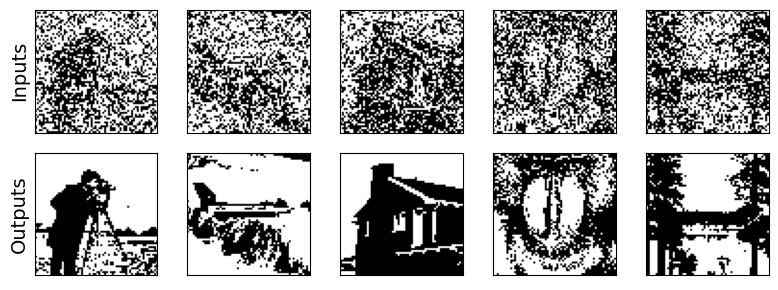

In [10]:
figure(figsize=(8, 3))
for i in 1:num_data
    subplot(2, num_data, i); imshow(imgs_corrupted[i], cmap="gray");  
    xticks([]); yticks([]); if i==1 ylabel("Inputs", fontsize=14) end;
    subplot(2, num_data, i+num_data); imshow(imgs_predicted[i], cmap="gray");  
    xticks([]); yticks([]); if i==1 ylabel("Outputs", fontsize=14) end;
end
tight_layout()